In [1]:
import numpy as np
import matplotlib.pyplot as plt
import itertools
from tqdm import tqdm

In [2]:
def factor_function(sigma_i, sigma_j, permutation, d):
    final = 1
    permutation = np.insert(permutation, 0, sigma_j)
    for j in range(d):
        if permutation[j]==1:
            if sigma_i + np.sum(permutation) - permutation[j] == 0:
                final *= 1
            else:
                final *= 0
        if final == 0:
            return 0
    return final

In [3]:
def BP(d, mu=0, tol=1e-12, max_iter=10000, damping_parameter=0.5, verbose=0, init_psi=None):
    psi=np.zeros((2,2))
    if init_psi is None:
        psi=np.random.uniform(size=(2,2))
        psi=psi/np.sum(psi)
    else:
        psi=init_psi.copy()
    
    permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
    
    for t in range(max_iter):
        psi_new=np.zeros((2,2))
        for i in range(2):
            for j in range(2):
                for perm in permutations:
                    mult=1
                    if factor_function(i, j, perm, d)==0:
                        continue
                    for k in perm:
                        mult*=psi[k,i]
                    psi_new[i,j]+=np.exp(mu*i)*mult
                    
        if np.sum(psi_new)!=0:
            psi_new=psi_new/np.sum(psi_new)
        else:
            psi_new=np.array([[0.25, 0.25],[0.25, 0.25]])
        
        psi_new=damping_parameter*psi+(1-damping_parameter)*psi_new
        
        Delta=np.linalg.norm(psi_new-psi)
        if verbose==2 and t%100==0:
            print("Iter : ", t+1, " Delta : ", Delta)
        psi=psi_new
        if Delta<tol:
            break
    
    if t==max_iter-1:
        print("No convergence"+" ! Final error: "+ str(Delta))
    else:
        if verbose>=1:
            print("Converged ! Number of iteration "+str(t))
    
    return psi

In [4]:
test = BP(3, mu=3, verbose=0)
print(test)

[[4.42295206e-01 1.57391202e-01]
 [4.00313593e-01 3.82911368e-19]]


In [5]:
def update_observables(psi, mu, d):
        phi_=0
        phi__=0
        permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
        numerator=0
        for i in range(2):
            for j in range(2):
                for perm in permutations:
                    if factor_function(i, j, perm, d)==0:
                        continue
                    mult=psi[j,i]
                    for k in perm:
                        mult*=psi[k,i]
                    phi_+=np.exp(mu*i)*mult
                    numerator+=i*np.exp(mu*i)*mult
                phi__+=psi[i,j]*psi[j,i]

        if phi_==0:
            phi_=1e-16
        if phi__==0:
            phi__=1e-16
        phi=np.log(phi_)-d/2*np.log(phi__)

        if numerator==0:
            rho=0
        else:
            rho=numerator/phi_
            
        s=phi-mu*rho

        return phi, rho, s

##to confirm at the end
def density_numerical(phi_list, mu_list):
    N=phi_list.size
    rho=np.zeros(N-1)
    for i in range(N-1):
        rho[i]=(phi_list[i+1]-phi_list[i])/(mu_list[i+1]-mu_list[i])
    return rho

In [6]:
def find_zero_bisection(arr):
    # Function to find zero using bisection method
    left = 0
    right = len(arr) - 1
    if(arr[left]*arr[right] > 0):
        print("No zero crossing found")
        return -1

    while right - left > 1:
        mid = (left + right) // 2
        if arr[mid] == 0:
            return mid  # Zero found at index 'mid'
        elif arr[mid] * arr[left] < 0:
            right = mid
        else:
            left = mid

    # If exact zero not found, return the index closest to zero
    return left if abs(arr[left]) < abs(arr[right]) else right

In [7]:
mu_space = np.linspace(7.2, 7.4, 10)
d = 3
phi_list = []
rho_list = []
s_list = []
for mu in mu_space:
    psi = BP(d, mu=mu, verbose=0)
    phi, rho, s = update_observables(psi, mu, d)
    phi_list.append(phi)
    rho_list.append(rho)
    s_list.append(s)


mu_crit_index = find_zero_bisection(s_list)
mu_crit = mu_space[mu_crit_index]
s_crit = s_list[mu_crit_index]
rho_crit = rho_list[mu_crit_index]
print(s_list)
print(phi_list)

No zero crossing found
[0.026751986042095277, 0.026011488015461826, 0.025273066839059943, 0.024536722501968367, 0.02380245498512701, 0.023070264180299116, 0.022340149876686644, 0.0216121118562147, 0.02088614977003811, 0.02016226322656567]
[1.6974033265940343, 1.7025607999961878, 1.7077205486655298, 1.7128825592519754, 1.718046818487107, 1.7232133131836513, 1.7283820302349493, 1.7335529566144432, 1.738726079375154, 1.7439013856491712]


/var/folders/vg/b1j027cd3vjcqjtbx_ggb3p40000gn/T/ipykernel_82625/2194310409.py:4: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "bo" (-> color='b'). The keyword argument will take precedence.
  plt.plot(mu_crit, s_crit, 'bo', color='tab:blue')
/var/folders/vg/b1j027cd3vjcqjtbx_ggb3p40000gn/T/ipykernel_82625/2194310409.py:5: UserWarning: color is redundantly defined by the 'color' keyword argument and the fmt string "ro" (-> color='r'). The keyword argument will take precedence.
  plt.plot(mu_crit, rho_crit, 'ro', color='tab:red', label=r'Densest packing $\rho_s$')


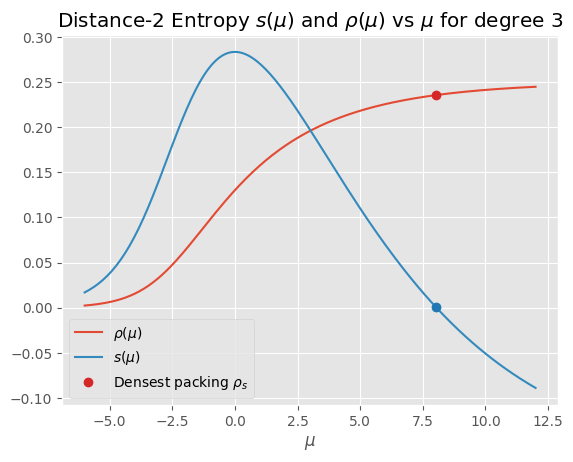

In [50]:
plt.style.use('ggplot')
plt.plot(mu_space, rho_list, label=r'$\rho(\mu)$')
plt.plot(mu_space, s_list, label=r'$s(\mu)$')
plt.plot(mu_crit, s_crit, 'bo', color='tab:blue')
plt.plot(mu_crit, rho_crit, 'ro', color='tab:red', label=r'Densest packing $\rho_s$')
plt.title(r'Distance-2 Entropy $s(\mu)$ and $\rho(\mu)$ vs $\mu$ for degree 3')
plt.legend()
plt.xlabel(r'$\mu$')

plt.show()

In [9]:
print(find_zero_bisection(s_list))

155


In [14]:
def complete_run(d, mu_space, verbose=0, max_iter=100000, damping_parameter=0.8):
    phi_list = []
    rho_list = []
    s_list = []
    for mu in mu_space:
        psi = BP(d, mu=mu, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        phi, rho, s = update_observables(psi, mu, d)
        phi_list.append(phi)
        rho_list.append(rho)
        s_list.append(s)

    zero_index = find_zero_bisection(s_list)
    if zero_index == -1:
        return -1
    return rho_list[zero_index], mu_space[zero_index], s_list[zero_index]

In [19]:
densest_packing, mu_critical, entropy = complete_run(3, np.linspace(4, 9, 200), verbose=0, max_iter=100000, damping_parameter=0.8)

In [20]:
print("Critical mu: ", mu_critical) 
print("Densest packing: ", densest_packing)
print("Entropy: ", entropy)

Critical mu:  8.045226130653266
Densest packing:  0.23554577233296395
Entropy:  4.509984312495163e-05


In [21]:
mu_space = np.linspace(7, 9, 200)
d = 3
phi_list = []
rho_list = []
s_list = []
for mu in mu_space:
    psi = BP(d, mu=mu, verbose=0)
    phi, rho, s = update_observables(psi, mu, d)
    phi_list.append(phi)
    rho_list.append(rho)
    s_list.append(s)

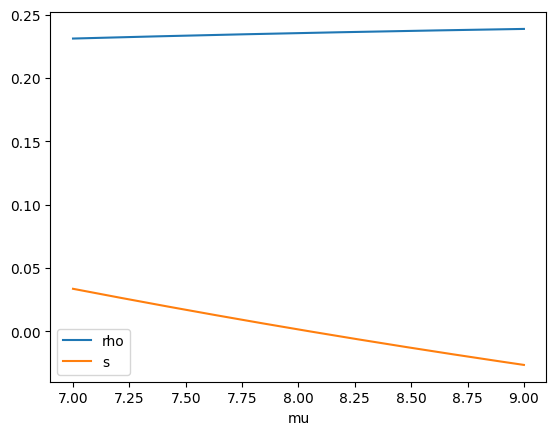

In [22]:
plt.plot(mu_space, rho_list, label='rho')
plt.plot(mu_space, s_list, label='s')
plt.xlabel('mu')
plt.legend()
plt.show()

In [29]:
d_list = [9, 10]
densest_packings = {}
mu_space = np.linspace(2, 10, 200)
for d in tqdm(d_list):
    densest_packings[d] = complete_run(d, mu_space)

100%|██████████| 2/2 [13:41<00:00, 410.74s/it]


In [30]:
print(densest_packings)

{9: 0.06496795358948015, 10: 0.056271843871893164}


In [15]:
densest_packings_1 = [0.4591, 0.4206, 0.3887, 0.3620, 0.3394, 0.3200, 0.3031, 0.2882]
densest_packings_2 = [0.2355, 0.1757, 0.1367, 0.1100, 0.0905, 0.0761, 0.0650, 0.0563]
degree = [3,4,5,6,7,8,9,10]
comparison = []
comparison_2 = []
subtract = densest_packings_1[0]-densest_packings_2[0]
for idx, d in enumerate(degree):
    comparison.append(densest_packings_1[idx]/d)
    comparison_2.append(densest_packings_1[idx]-subtract)

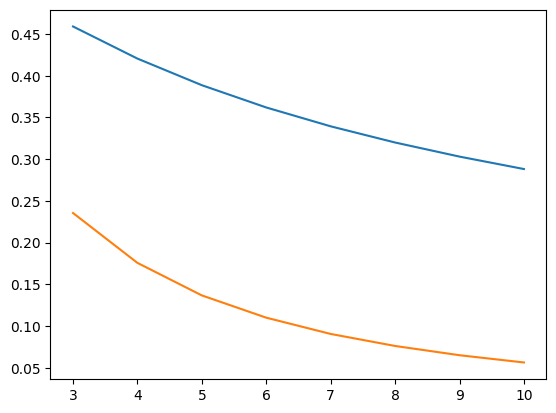

In [4]:
plt.plot(degree, densest_packings_1, label='Distance 1')
plt.plot(degree, densest_packings_2, label='Distance 2')

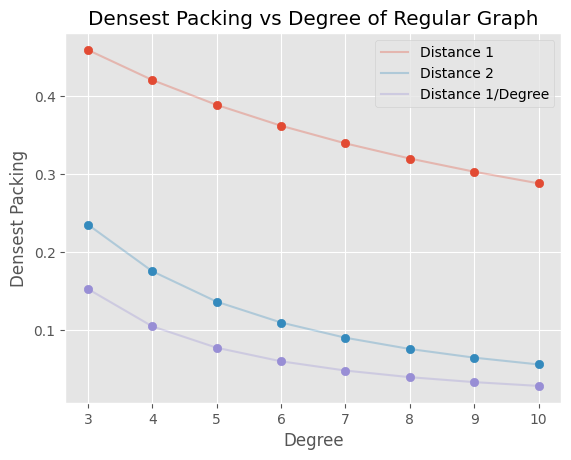

<Figure size 640x480 with 0 Axes>

In [13]:
plt.style.use('ggplot')

plt.scatter(degree, densest_packings_1)
plt.plot(degree, densest_packings_1, alpha=0.3, label='Distance 1'   )

plt.scatter(degree, densest_packings_2)
plt.plot(degree, densest_packings_2, alpha=0.3, label='Distance 2')

plt.scatter(degree, comparison)
plt.plot(degree, comparison, alpha=0.3, label='Distance 1/Degree')

plt.xlabel('Degree')
plt.ylabel('Densest Packing')
plt.title('Densest Packing vs Degree of Regular Graph')
plt.legend()
plt.savefig('densest_packings.png')
plt.show()
plt.savefig('densest_packings.png')


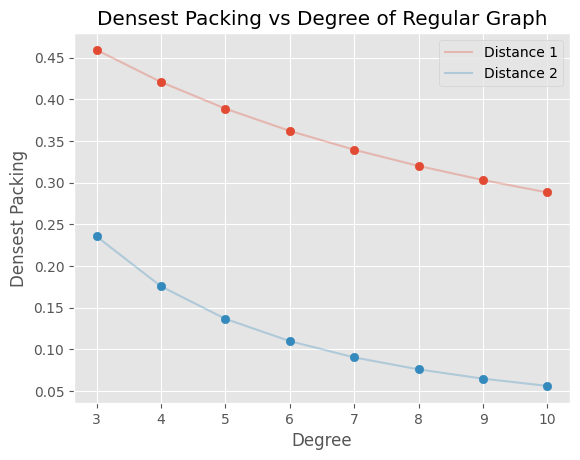

<Figure size 640x480 with 0 Axes>

In [14]:
plt.style.use('ggplot')

plt.scatter(degree, densest_packings_1)
plt.plot(degree, densest_packings_1, alpha=0.3, label='Distance 1')

plt.scatter(degree, densest_packings_2)
plt.plot(degree, densest_packings_2, alpha=0.3, label='Distance 2')


plt.xlabel('Degree')
plt.ylabel('Densest Packing')
plt.title('Densest Packing vs Degree of Regular Graph')
plt.legend()
plt.savefig('densest_packings.png')
plt.show()
plt.savefig('densest_packings.png')

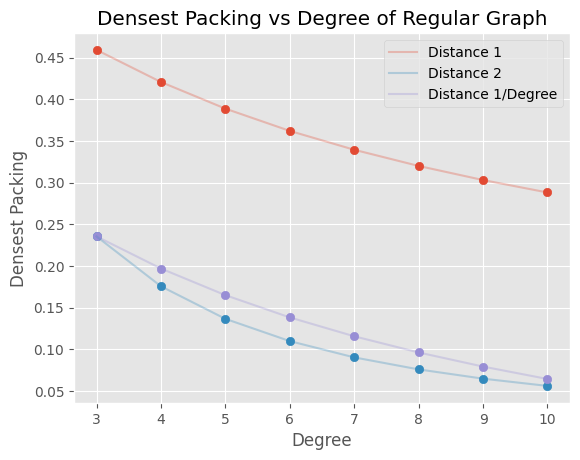

<Figure size 640x480 with 0 Axes>

In [18]:
plt.style.use('ggplot')

plt.scatter(degree, densest_packings_1)
plt.plot(degree, densest_packings_1, alpha=0.3, label='Distance 1'   )

plt.scatter(degree, densest_packings_2)
plt.plot(degree, densest_packings_2, alpha=0.3, label='Distance 2')

plt.scatter(degree, comparison_2)
plt.plot(degree, comparison_2, alpha=0.3, label='Distance 1/Degree')

plt.xlabel('Degree')
plt.ylabel('Densest Packing')
plt.title('Densest Packing vs Degree of Regular Graph')
plt.legend()
plt.savefig('densest_packings.png')
plt.show()
plt.savefig('densest_packings.png')

Stability Analysis

In [1]:
import sympy as sp

In [15]:
def bp_update_equation(d, psi, mu):
    permutations=np.array(list(itertools.product([0,1], repeat=d-1)))
    psi_new = sp.zeros(2, 2)
    for i in range(2):
        for j in range(2):
            for perm in permutations:
                mult = 1
                if factor_function(i, j, perm, d) == 0:
                    continue
                for k in perm:
                    mult *= psi[k, i]
                psi_new[i, j] += sp.exp(mu*i)*mult
    sum_elements = sp.Add(*psi_new)
    psi_new = psi_new/sum_elements
    return psi_new

def BP_jacobian_max_eigenvalue(d, psi_fixed_point, mu_num):
    psi_00 = sp.symbols('psi_00', real=True)
    psi_01 = sp.symbols('psi_01', real=True)
    psi_10 = sp.symbols('psi_10', real=True)
    psi_11 = sp.symbols('psi_11', real=True)
    psi = sp.Matrix([[psi_00, psi_01], [psi_10, psi_11]])
    mu = sp.symbols('mu', real=True)
    psi_new = bp_update_equation(d, psi, mu)

    psi_new = psi_new.reshape(4, 1)
    psi_vec = psi.reshape(4, 1)
    
    jacobian_result = psi_new.jacobian(psi_vec)

    numerical_values = {psi_00: psi_fixed_point[0,0], psi_01: psi_fixed_point[0,1], psi_10: psi_fixed_point[1,0], psi_11: psi_fixed_point[1,1], mu: mu_num}

    eigenvalues = jacobian_result.eigenvals()

    numerical_eigenvalues = [e.evalf(subs=numerical_values) for e in eigenvalues]

    largest_eigenvalue = max(np.abs(numerical_eigenvalues))
    
    return largest_eigenvalue

In [29]:
def linear_stability_analysis(d, mu_space, verbose=0, max_iter=100000, damping_parameter=0.8):
    stability_parameters = []
    rho_list = []
    for mu in tqdm(mu_space):
        BP_fixed_point = BP(d, mu=mu, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        largest_eigenvalue = BP_jacobian_max_eigenvalue(d, BP_fixed_point, mu)
        c_tilde = 1/(d-1)
        stability_parameters.append(largest_eigenvalue**2*c_tilde-1)
        phi, rho, s = update_observables(BP_fixed_point, mu, d)
        rho_list.append(rho)
        # if s < 0:
        #     print("Entropy became negative at mu = ", mu)
        #     break

    zero_index = find_zero_bisection(stability_parameters)
    if zero_index == -1:
        return -1, -1, stability_parameters
    return mu_space[zero_index], rho_list[zero_index], stability_parameters
    

In [32]:
mu_space = np.linspace(2, 20, 50)
stability_mu, stability_densest_packing, stability_params = linear_stability_analysis(3, mu_space)

100%|██████████| 50/50 [00:22<00:00,  2.27it/s]

No zero crossing found


In [31]:
print(stability_params)

[-0.441008161583631, -0.433611038360231, -0.426303218670097, -0.419085337949727, -0.411957920897012, -0.404921387297726, -0.397976057658263, -0.391122158627586, -0.384359828226993, -0.377689120863206, -0.371110012162865, -0.364622403593311, -0.358226126912818, -0.351920948407221, -0.345706572971208, -0.339582647999837, -0.333548767099616, -0.327604473648751, -0.321749264181837, -0.315982591626297, -0.310303868378516, -0.304712469243784, -0.299207734227152, -0.293788971194373, -0.288455458397001, -0.283206446872680, -0.278041162734142, -0.272958809326368, -0.267958569286681, -0.263039606492095, -0.258201067907802, -0.253442085332608, -0.248761777061013, -0.244159249442989, -0.239633598371167, -0.235183910678210, -0.230809265462379, -0.226508735332745, -0.222281387586224, -0.218126285321008, -0.214042488474588, -0.210029054817680, -0.206085040871689, -0.202209502782408, -0.198401497133081, -0.194660081707148, -0.190984316220986, -0.187373262979281, -0.183825987509688, -0.180341559151095,

In [24]:
def complete_run_stability(verbose=0, max_iter=10000, damping_parameter=0.6):
    mu_space = np.linspace(2, 6, 400)
    d_list = [3, 4, 5, 6, 7, 8, 9, 10]
    stability_densest_packing_list = []
    mu_stability_list = []
    for d in d_list:
        stability_mu, stability_densest_packing, stability_params = linear_stability_analysis(d, mu_space, verbose=verbose, max_iter=max_iter, damping_parameter=damping_parameter)
        stability_densest_packing_list.append(stability_densest_packing)
        mu_stability_list.append(stability_mu)
        print("Degree: ", d, "Stability mu: ", stability_mu, "Stability densest packing: ", stability_densest_packing)

    return mu_stability_list, stability_densest_packing_list

In [25]:
mu_stability_list, stability_densest_packing_list = complete_run_stability()

  0%|          | 0/400 [00:00<?, ?it/s]

100%|██████████| 400/400 [48:10<00:00,  7.23s/it]    


No zero crossing found
Degree:  3 Stability mu:  -1 Stability densest packing:  -1


100%|██████████| 400/400 [03:27<00:00,  1.92it/s]


No zero crossing found
Degree:  4 Stability mu:  -1 Stability densest packing:  -1


100%|██████████| 400/400 [03:59<00:00,  1.67it/s]


No zero crossing found
Degree:  5 Stability mu:  -1 Stability densest packing:  -1


100%|██████████| 400/400 [04:53<00:00,  1.36it/s]


No zero crossing found
Degree:  6 Stability mu:  -1 Stability densest packing:  -1


100%|██████████| 400/400 [59:00<00:00,  8.85s/it]    


No zero crossing found
Degree:  7 Stability mu:  -1 Stability densest packing:  -1


100%|██████████| 400/400 [42:16<00:00,  6.34s/it]   


No zero crossing found
Degree:  8 Stability mu:  -1 Stability densest packing:  -1


100%|██████████| 400/400 [58:14<00:00,  8.74s/it]   


No zero crossing found
Degree:  9 Stability mu:  -1 Stability densest packing:  -1


 86%|████████▋ | 346/400 [5:04:07<2:24:36, 160.68s/it] 

No convergence ! Final error: 7.022358539042326e-12


 87%|████████▋ | 347/400 [5:06:04<2:10:27, 147.68s/it]

No convergence ! Final error: 8.81170227794671e-11


 87%|████████▋ | 348/400 [5:08:01<2:00:07, 138.60s/it]

No convergence ! Final error: 8.482147582075049e-10


 87%|████████▋ | 349/400 [5:33:44<48:46, 57.38s/it]   


KeyboardInterrupt: 